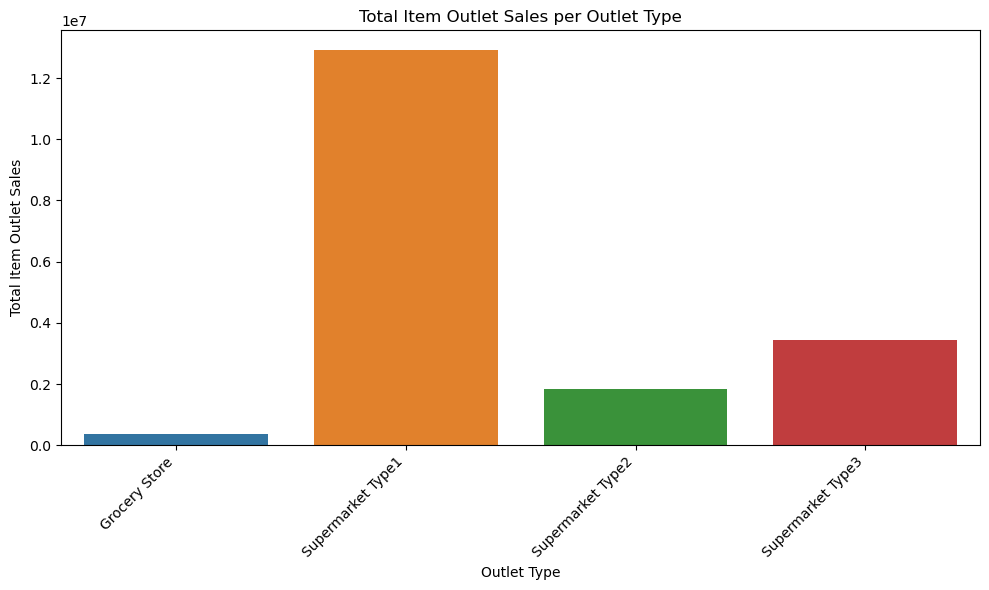

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import numpy as np # linear algebra
import pandas as pd # data processing
import math
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from xgboost import XGBRegressor
import optuna

# Ignore warnings ;)
import warnings
warnings.simplefilter("ignore")

import pickle

# set seed for reproductibility
np.random.seed(0)


# Load the training data
train_df = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\train_v9rqX0R.csv')
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x != 'Regular' else x)

# Group by 'Outlet_Type' and calculate the sum of 'Item_Outlet_Sales'
sales_by_outlet_type = train_df.groupby('Outlet_Type')['Item_Outlet_Sales'].sum().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Outlet_Type', y='Item_Outlet_Sales', data=sales_by_outlet_type)
plt.title('Total Item Outlet Sales per Outlet Type')
plt.xlabel('Outlet Type')
plt.ylabel('Total Item Outlet Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



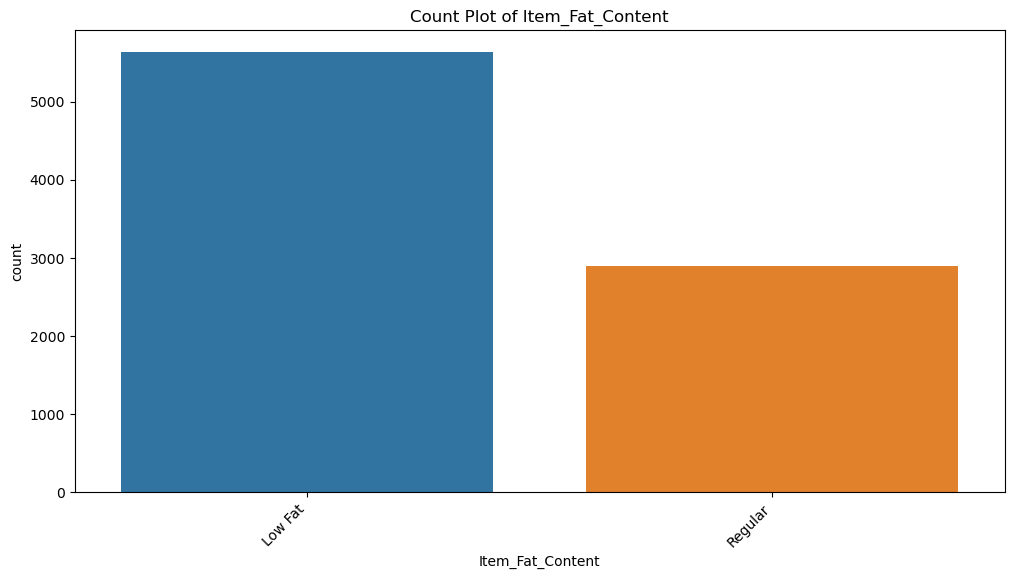

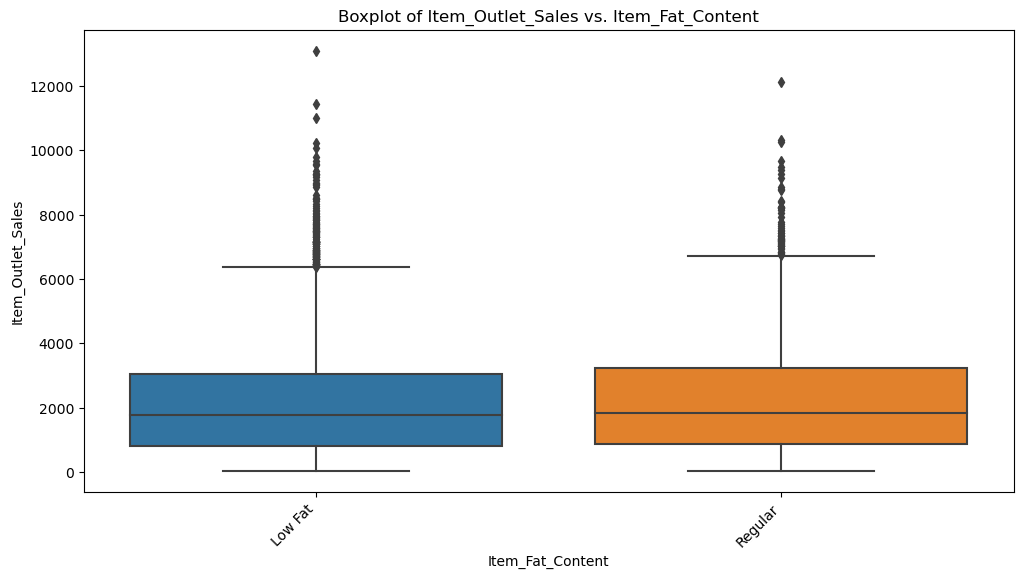

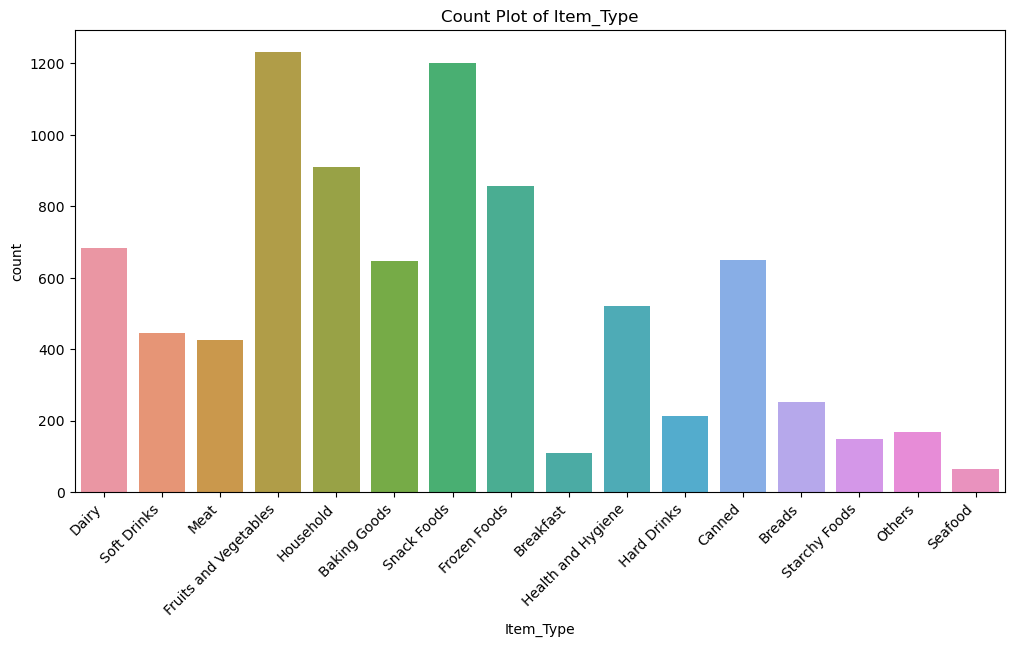

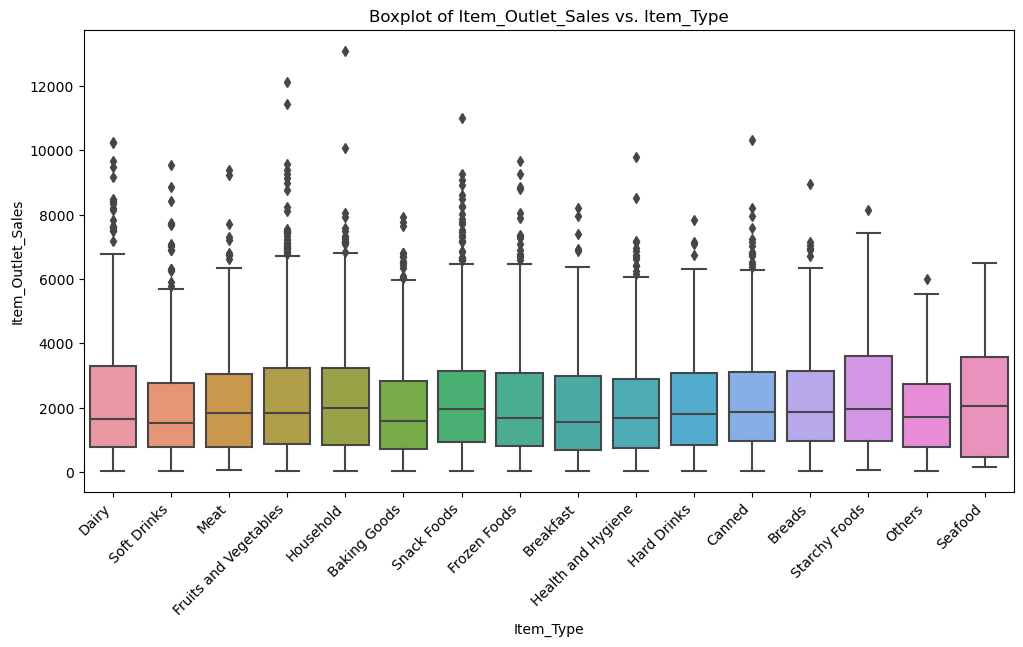

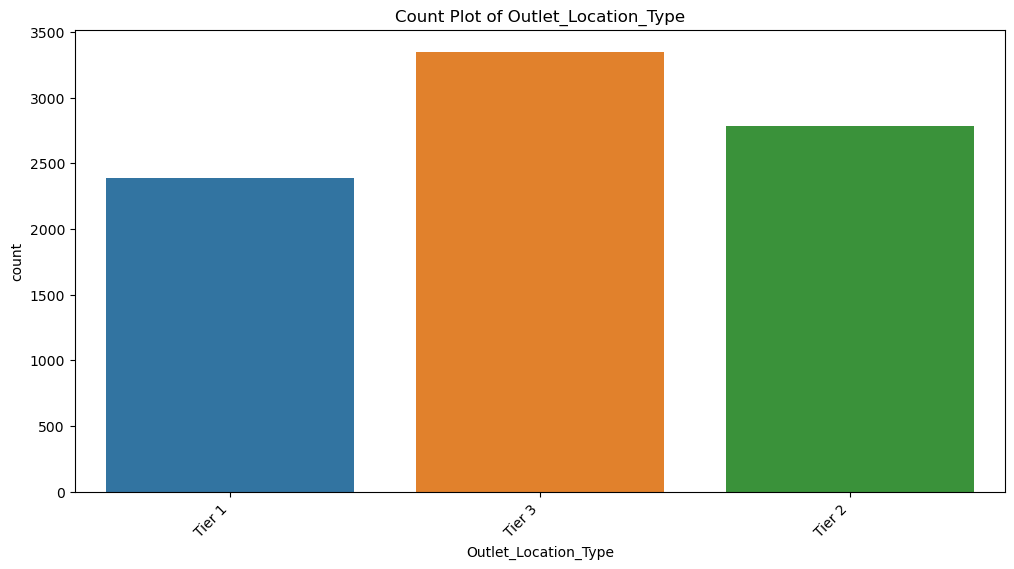

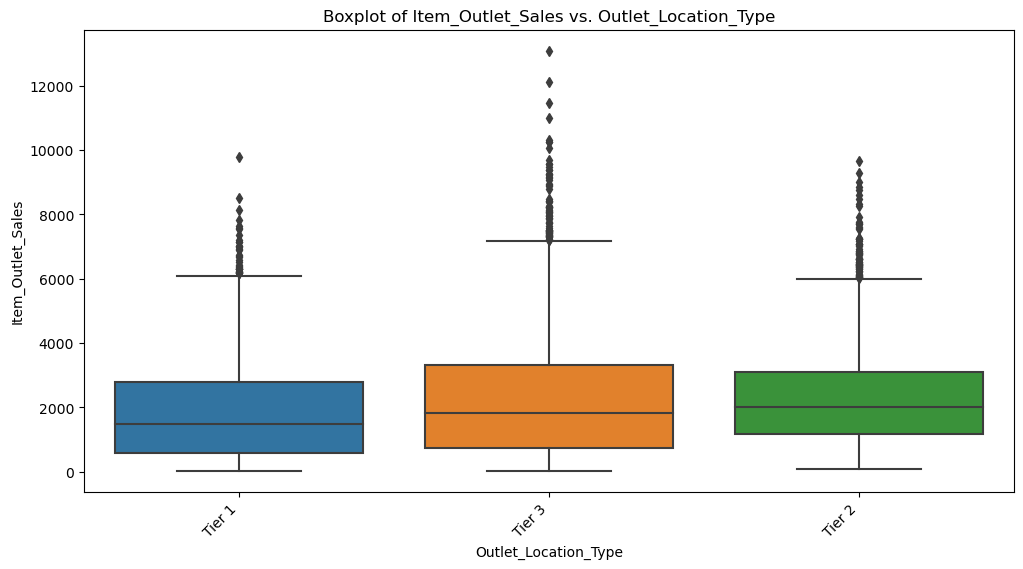

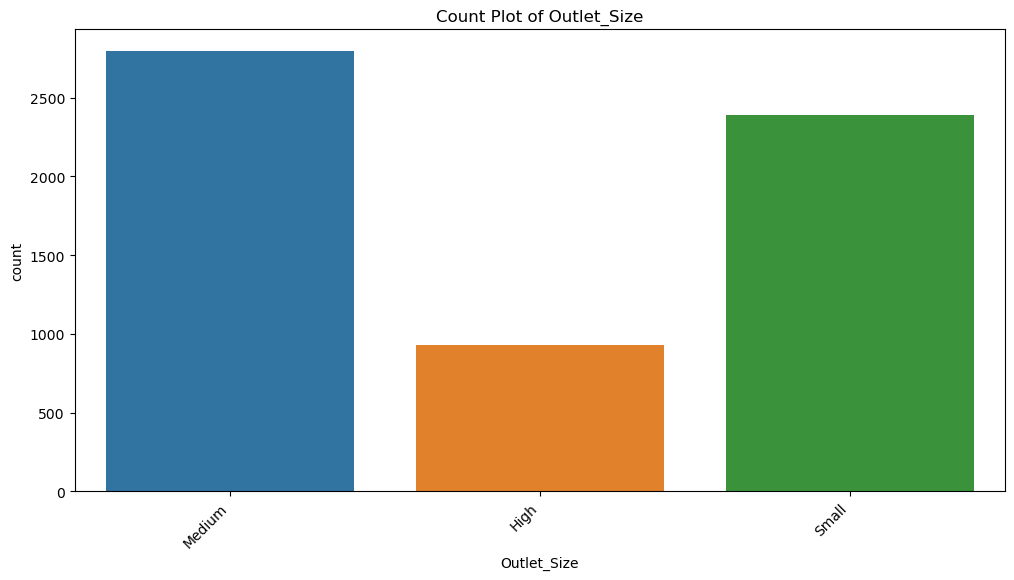

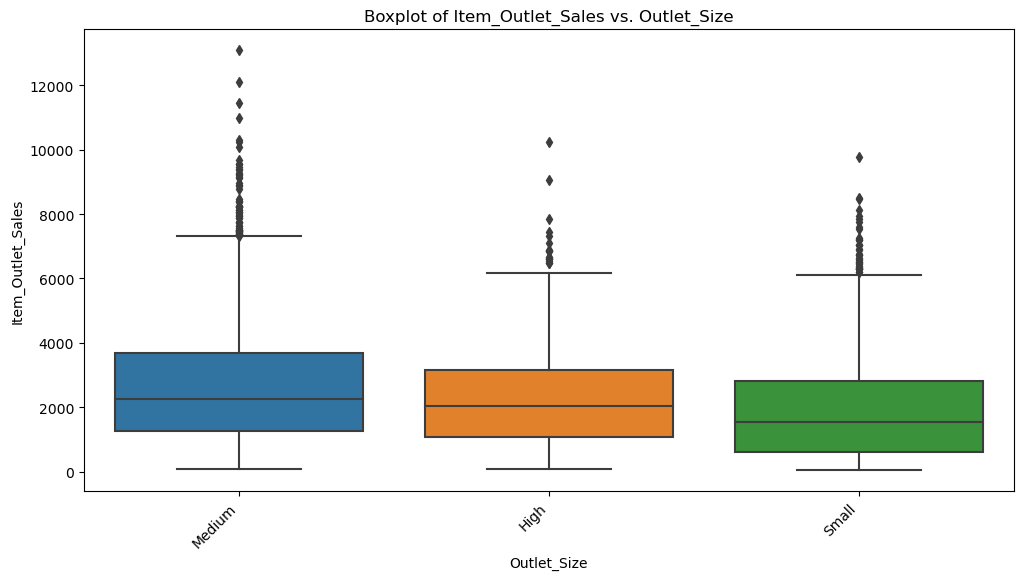

In [2]:
train_df_cat = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\train_v9rqX0R.csv')
train_df_cat['Item_Fat_Content'] = train_df_cat['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x != 'Regular' else x)
categorical_features_before_encoding = ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Size']

target = 'Item_Outlet_Sales'

for feature in categorical_features_before_encoding:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=train_df_cat, x=feature)
    plt.title(f'Count Plot of {feature}')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=train_df_cat, x=feature, y=target)
    plt.title(f'Boxplot of {target} vs. {feature}')
    plt.xticks(rotation=45, ha='right')
    plt.show()



# Supermarket Type 2

In [3]:
# Supermarket Type 2



# Load the data
train_df = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\train_v9rqX0R.csv')
train_df = train_df.loc[train_df['Outlet_Type'].isin(['Supermarket Type2'])].reset_index(drop = True)
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x != 'Regular' else x)
#### Transformation of LF, low fat to Low Fat"

test_df = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\test_AbJTz2l.csv')
test_df = test_df.loc[test_df['Outlet_Type'].isin(['Supermarket Type2'])].reset_index(drop = True)
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x != 'Regular' else x)
#### Transformation of LF, low fat to Low Fat"


original_test_df = test_df.copy() # Keep a copy for submission

target = 'Item_Outlet_Sales'

# --- Helper Functions ---
def impute_item_weight(df):
    item_weight_mean = df.groupby('Item_Identifier')['Item_Weight'].transform('mean')
    df['Item_Weight'].fillna(item_weight_mean, inplace=True)
    df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True) # For any remaining NaNs
    return df

def impute_outlet_size(df_train, df_test):
    outlet_size_mode = df_train.groupby(['Outlet_Type', 'Outlet_Location_Type'])['Outlet_Size'].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
    df_train['Outlet_Size'] = df_train.apply(lambda row: outlet_size_mode[(row['Outlet_Type'], row['Outlet_Location_Type'])] if pd.isnull(row['Outlet_Size']) and (row['Outlet_Type'], row['Outlet_Location_Type']) in outlet_size_mode else row['Outlet_Size'], axis=1)
    df_test['Outlet_Size'] = df_test.apply(lambda row: outlet_size_mode.get((row['Outlet_Type'], row['Outlet_Location_Type']), df_train['Outlet_Size'].mode()[0]) if pd.isnull(row['Outlet_Size']) else row['Outlet_Size'], axis=1)
    return df_train, df_test

def handle_item_visibility(df):
    df['Item_Visibility'] = np.where(df['Item_Visibility'] == 0, df['Item_Visibility'].median(), df['Item_Visibility'])
    return df

def feature_engineer(df):
    df['Outlet_Age'] = 2025 - df['Outlet_Establishment_Year']
    df['Item_Type_Combined'] = df['Item_Type'].apply(lambda x: x[:4])
    df['Item_Visibility_Ratio'] = df.groupby('Item_Identifier')['Item_Visibility'].transform(lambda x: x / (x.mean() + 1e-6)) # Avoid division by zero
    return df

def encode_categorical(df_train, df_test):
    le = LabelEncoder()
    df_train['Outlet'] = le.fit_transform(df_train['Outlet_Identifier'])
    df_test['Outlet'] = le.transform(df_test['Outlet_Identifier'])

    categorical_cols = ['Item_Fat_Content', 'Item_Type_Combined', 'Outlet_Location_Type', 'Outlet_Size']
    df_train = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)
    df_test = pd.get_dummies(df_test, columns=categorical_cols, drop_first=True)
    return df_train, df_test

def align_columns(df_train, df_test, target):
    train_cols = set(df_train.columns)
    test_cols = set(df_test.columns)

    missing_in_test = list(train_cols - test_cols - {target})
    for col in missing_in_test:
        df_test[col] = 0

    missing_in_train = list(test_cols - train_cols)
    for col in missing_in_train:
        df_train[col] = 0

    df_test = df_test[df_train.drop(columns=[target]).columns]
    return df_train, df_test

# --- Data Preprocessing Pipeline ---
train_df = impute_item_weight(train_df)
test_df = impute_item_weight(test_df)

train_df, test_df = impute_outlet_size(train_df, test_df)

train_df = handle_item_visibility(train_df)
test_df = handle_item_visibility(test_df)

train_df = feature_engineer(train_df)
test_df = feature_engineer(test_df)

train_df, test_df = encode_categorical(train_df, test_df)

train_df.drop(['Item_Identifier', 'Outlet_Identifier', 'Item_Type', 'Outlet_Establishment_Year'], axis=1, inplace=True)
test_df.drop(['Item_Identifier', 'Outlet_Identifier', 'Item_Type', 'Outlet_Establishment_Year'], axis=1, inplace=True)

train_df, test_df = align_columns(train_df, test_df, target)



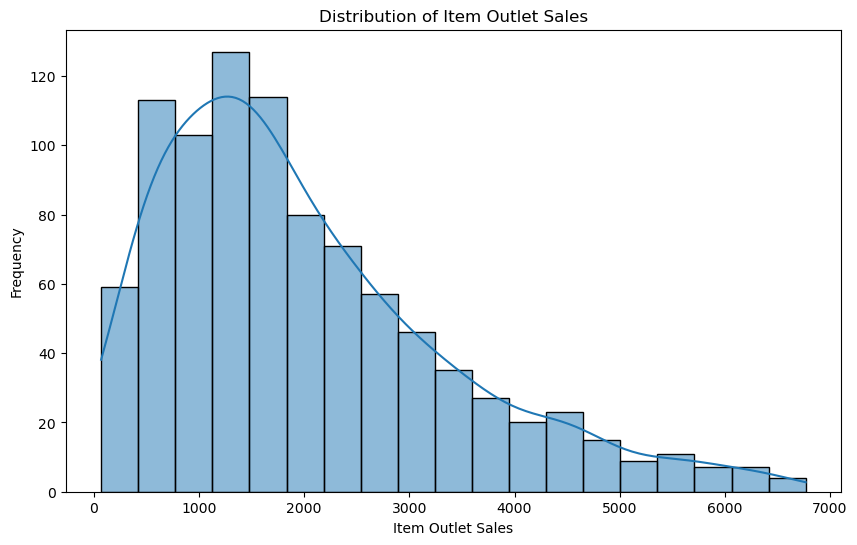

Skewness of Item Outlet Sales: 1.08


In [4]:

# --- Exploratory Data Analysis (EDA) ---

# 1. Understanding the Target Variable (`Item_Outlet_Sales`)
plt.figure(figsize=(10, 6))
sns.histplot(train_df[target], kde=True)
plt.title('Distribution of Item Outlet Sales')
plt.xlabel('Item Outlet Sales')
plt.ylabel('Frequency')
plt.show()

print(f"Skewness of Item Outlet Sales: {train_df[target].skew():.2f}")


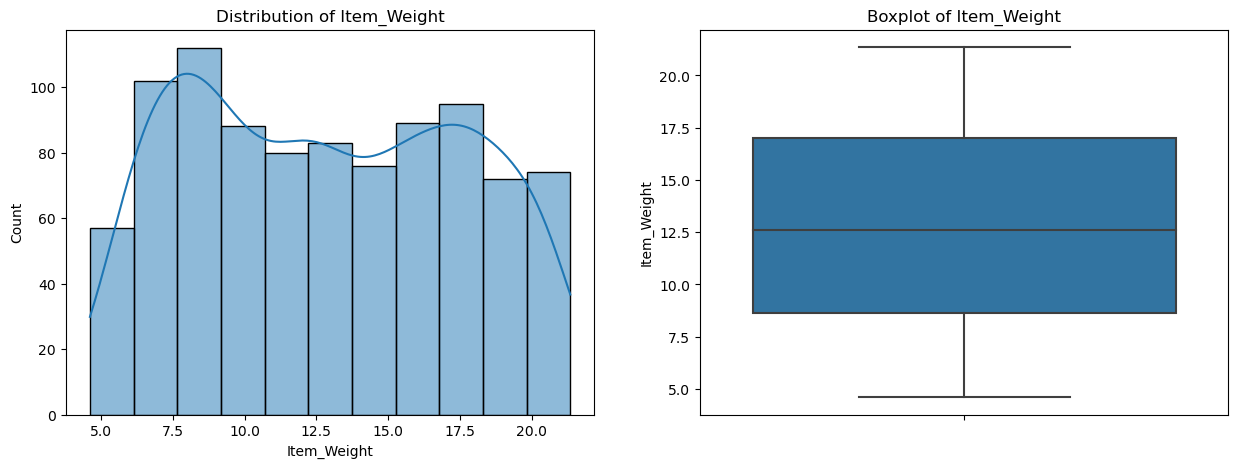

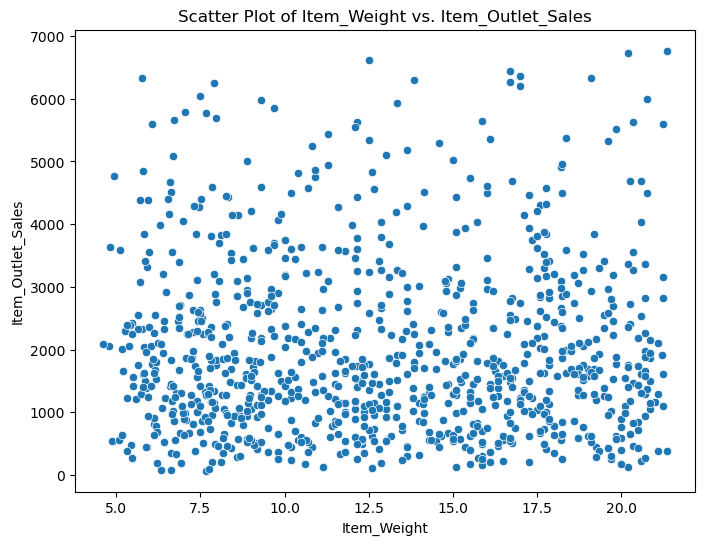

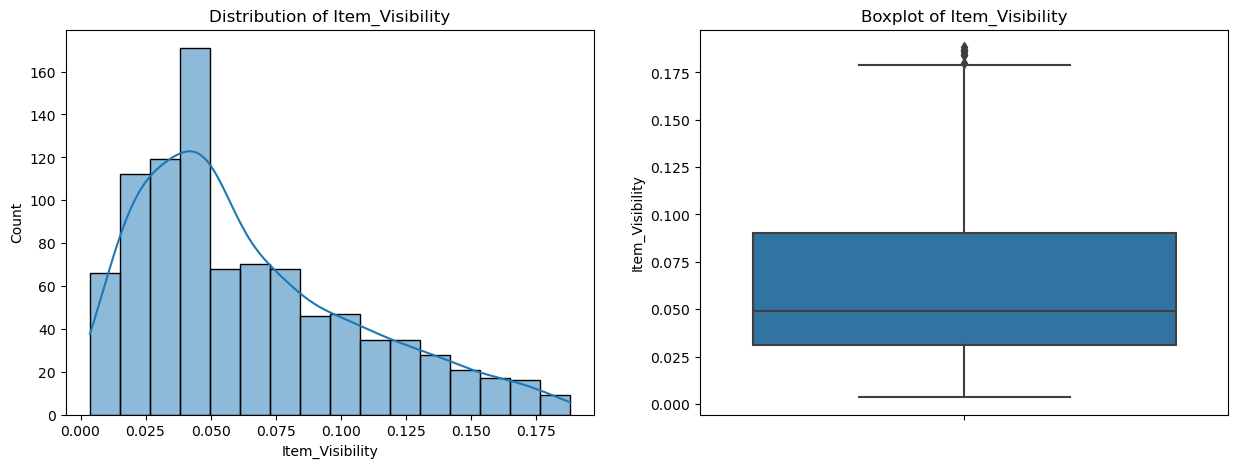

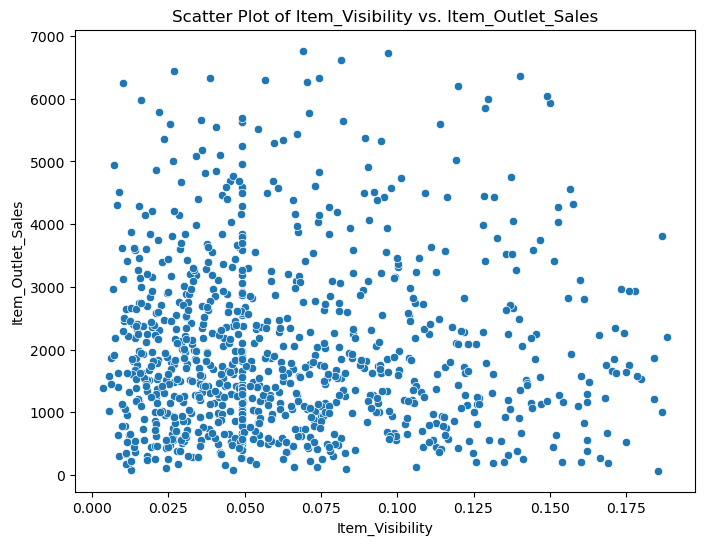

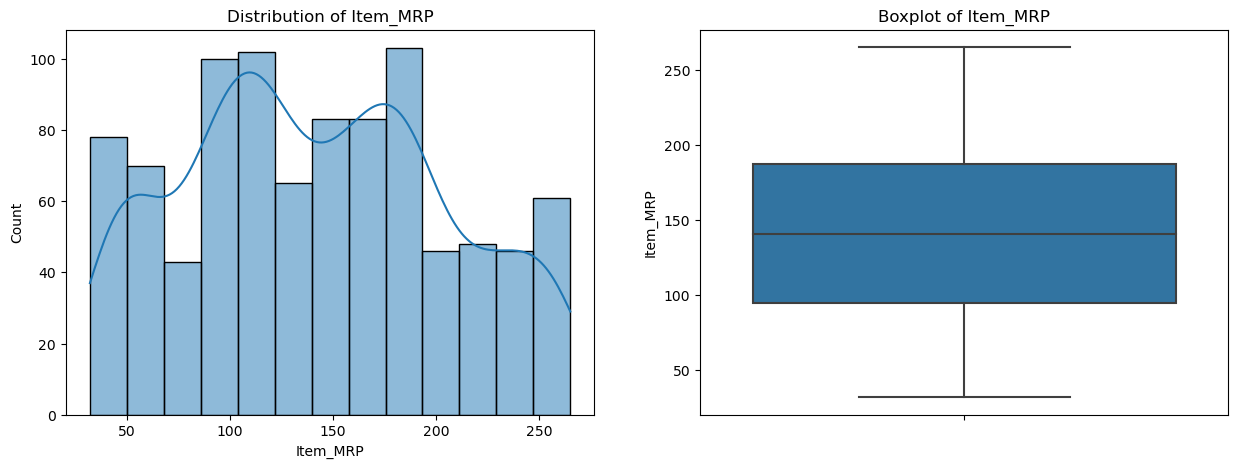

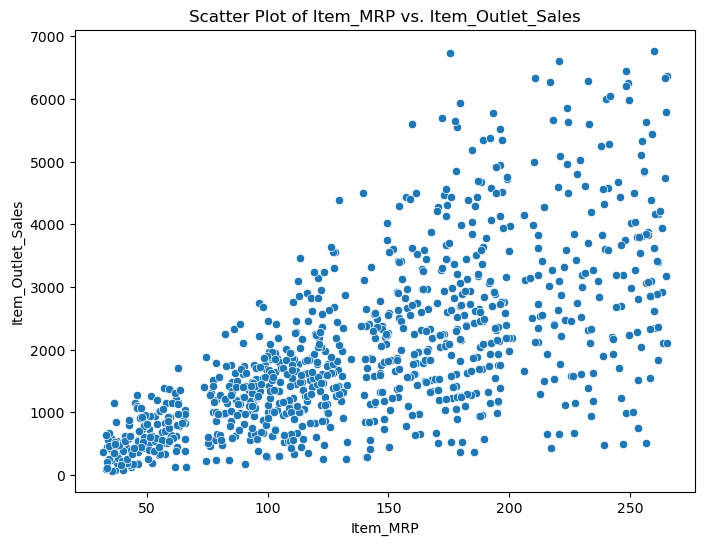

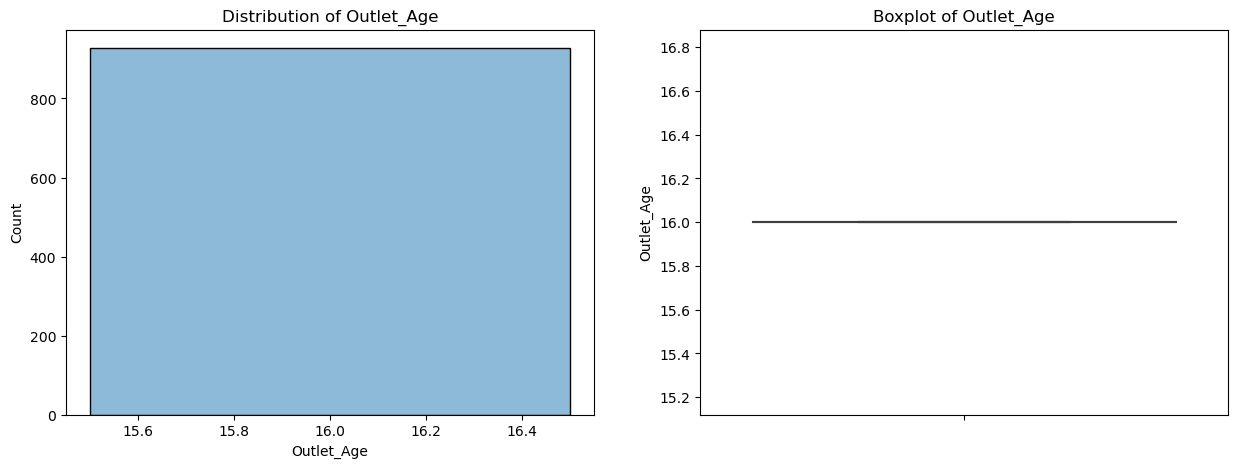

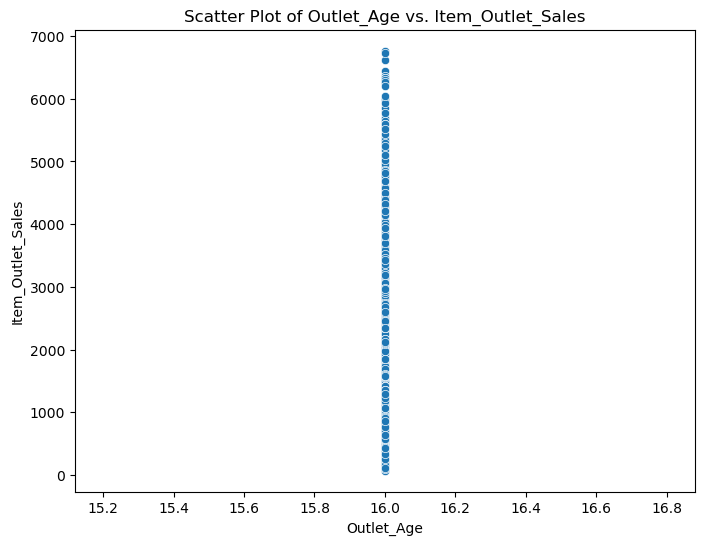

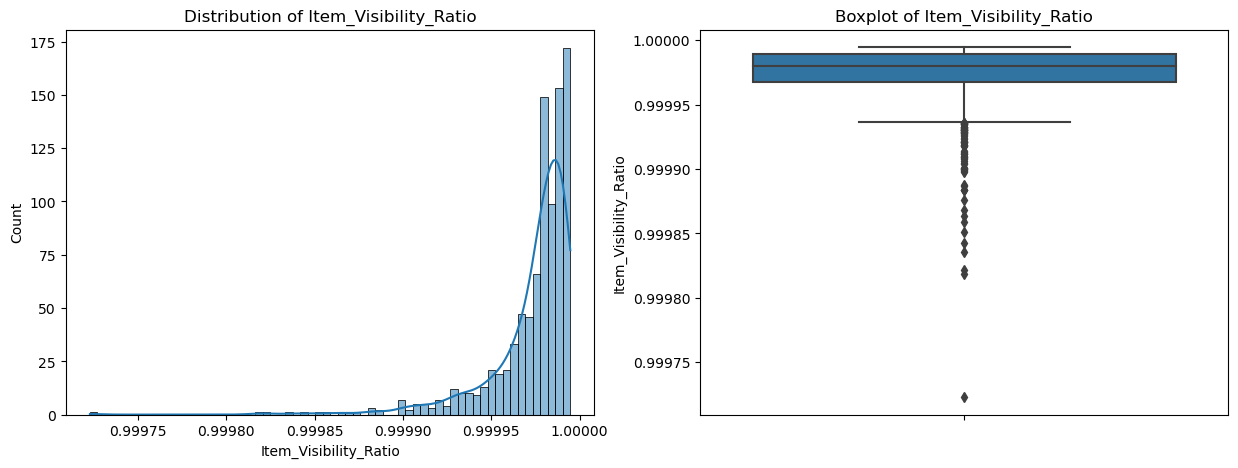

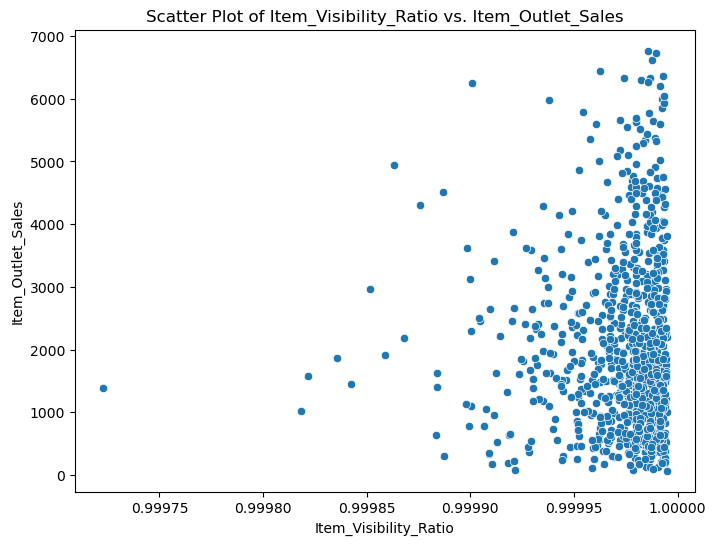

In [5]:

# 2. Exploring Numerical Features
numerical_features = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Age', 'Item_Visibility_Ratio']

for feature in numerical_features:
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(train_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=train_df[feature])
    plt.title(f'Boxplot of {feature}')

    plt.show()

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=train_df[feature], y=train_df[target])
    plt.title(f'Scatter Plot of {feature} vs. {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()


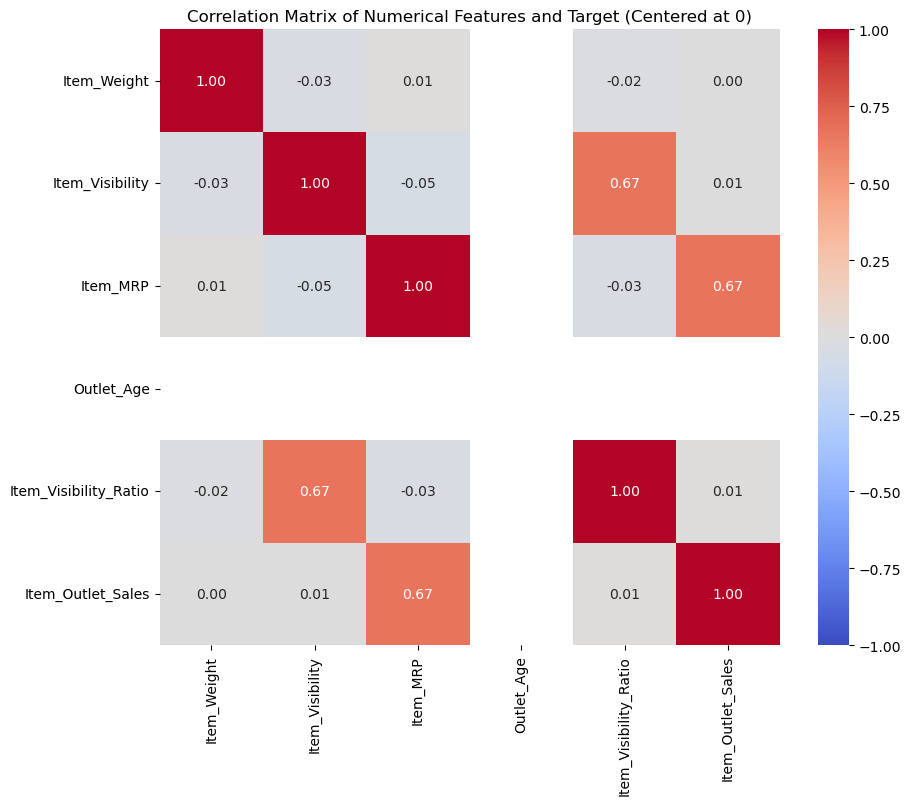

In [6]:
# 3. Exploring Relationships Between Features - Centered Color Scale

correlation_matrix = train_df[numerical_features + [target]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Numerical Features and Target (Centered at 0)')
plt.show()



In [7]:
# --- Model Selection and Training ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Prepare data for modeling
X = train_df.fillna(0)
X = X.drop(['Item_Outlet_Sales'],axis =1)
y = train_df[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_df.copy()



In [8]:
y = train_df[target]

corr = pd.concat([y,X],axis =1)
corr = corr.corr()[['Item_Outlet_Sales']]
corr = corr.loc[(corr['Item_Outlet_Sales'] > 0.05) | (corr['Item_Outlet_Sales'] < -0.05)].iloc[1:,:].reset_index(drop = False)
corr['index'].to_list()
corr



# corr

,index,Item_Outlet_Sales
0,Item_MRP,0.669502
1,Item_Type_Combined_Seaf,0.074245


In [9]:
# Prepare data for modeling
X = train_df[corr['index'].to_list()].fillna(0)
# X = X.drop(['Item_Outlet_Sales'],axis =1)
y = train_df[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_df.copy()


In [10]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
steps = [
            ('scaler', StandardScaler()),
            ('poly'  , PolynomialFeatures(degree=2)),
            ('model' , Lasso(alpha=30, fit_intercept=True))
       ]

ridge_pipeline = Pipeline(steps)
ridge_pipeline.fit(X_train, y_train)
ridge_predictions = ridge_pipeline.predict(X_val[corr['index'].to_list()])


ridge_mse  = mean_squared_error(y_val , ridge_predictions)
ridge_rmse = math.sqrt(ridge_mse)
ridge_r2   = r2_score(y_val, ridge_predictions)

print('lasso RMSE  \t         ----> {}'.format(ridge_rmse))
print('lasso R2 Score         ----> {}'.format(ridge_r2))

# print('Training Score  : {}'.format(ridge_pipeline.score(X_train, y_train)))
# print('Test Score      : {}'.format(ridge_pipeline.score(X_test, y_test)))

lasso RMSE  	         ----> 878.6529697371374
lasso R2 Score         ----> 0.39369200772495183


In [11]:
# --- Random Forest ---
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5)
rf_model.fit(X_train, y_train)
rf_pred_val_rf = rf_model.predict(X_train)
rmse_rf = mean_squared_error(y_train, rf_pred_val_rf, squared=False)
print(f'Random Forest Validation RMSE: {rmse_rf}')
rf_r2   = r2_score(y_train, rf_pred_val_rf)
print('Ridge R2 Score         ----> {}'.format(rf_r2))

# rf_predictions = rf_model.predict(X_test[corr['index'].to_list()])

# --- XGBoost ---
xgb_model = XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1, learning_rate=0.05, max_depth=7)
xgb_model.fit(X_train, y_train)
xgb_pred_val_xgb = xgb_model.predict(X_train)
rmse_xgb = mean_squared_error(y_train, xgb_pred_val_xgb, squared=False)
print(f'XGBoost Validation RMSE: {rmse_xgb}')
xgb_r2   = r2_score(y_train, xgb_pred_val_xgb)
print('Ridge R2 Score         ----> {}'.format(xgb_r2))

# xgb_predictions = xgb_model.predict(X_test[corr['index'].to_list()])

# You can further explore LightGBM and ensemble these models

Random Forest Validation RMSE: 667.4717671124606
Ridge R2 Score         ----> 0.7810905042241162
XGBoost Validation RMSE: 863.5424346689367
Ridge R2 Score         ----> 0.6335909708760821


In [12]:
rf_predictions = ridge_pipeline.predict(X_test[corr['index'].to_list()])
len(rf_predictions)

618

In [13]:
test_df_original = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\test_AbJTz2l.csv')
test_df_original = test_df_original.loc[test_df_original['Outlet_Type'].isin(['Supermarket Type2'])].reset_index(drop = True)
ridge_predictions_final = ridge_pipeline.predict(X_test[corr['index'].to_list()])
ridge_predictions_final
submission_df = pd.DataFrame({'Item_Identifier': test_df_original['Item_Identifier'], 'Outlet_Identifier': test_df_original['Outlet_Identifier'], 'Item_Outlet_Sales': rf_predictions})
# submission_df.to_csv('submission_ensemble.csv', index=False)
submission_df.to_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\Python Outputs\Final_lap_psuh_push\v13_2.csv', index = False)

# Supermarket Type 3

In [14]:

# Supermarket Type 3


# Load the data
train_df = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\train_v9rqX0R.csv')
train_df = train_df.loc[train_df['Outlet_Type'].isin(['Supermarket Type3'])].reset_index(drop = True)
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x != 'Regular' else x)
#### Transformation of LF, low fat to Low Fat"


test_df = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\test_AbJTz2l.csv')
test_df = test_df.loc[test_df['Outlet_Type'].isin(['Supermarket Type3'])].reset_index(drop = True)
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x != 'Regular' else x)
#### Transformation of LF, low fat to Low Fat"


original_test_df = test_df.copy() # Keep a copy for submission

target = 'Item_Outlet_Sales'

# --- Helper Functions ---
def impute_item_weight(df):
    item_weight_mean = df.groupby('Item_Identifier')['Item_Weight'].transform('mean')
    df['Item_Weight'].fillna(item_weight_mean, inplace=True)
    df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True) # For any remaining NaNs
    return df

def impute_outlet_size(df_train, df_test):
    outlet_size_mode = df_train.groupby(['Outlet_Type', 'Outlet_Location_Type'])['Outlet_Size'].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
    df_train['Outlet_Size'] = df_train.apply(lambda row: outlet_size_mode[(row['Outlet_Type'], row['Outlet_Location_Type'])] if pd.isnull(row['Outlet_Size']) and (row['Outlet_Type'], row['Outlet_Location_Type']) in outlet_size_mode else row['Outlet_Size'], axis=1)
    df_test['Outlet_Size'] = df_test.apply(lambda row: outlet_size_mode.get((row['Outlet_Type'], row['Outlet_Location_Type']), df_train['Outlet_Size'].mode()[0]) if pd.isnull(row['Outlet_Size']) else row['Outlet_Size'], axis=1)
    return df_train, df_test

def handle_item_visibility(df):
    df['Item_Visibility'] = np.where(df['Item_Visibility'] == 0, df['Item_Visibility'].median(), df['Item_Visibility'])
    return df

def feature_engineer(df):
    df['Outlet_Age'] = 2025 - df['Outlet_Establishment_Year']
    df['Item_Type_Combined'] = df['Item_Type'].apply(lambda x: x[:4])
    df['Item_Visibility_Ratio'] = df.groupby('Item_Identifier')['Item_Visibility'].transform(lambda x: x / (x.mean() + 1e-6)) # Avoid division by zero
    return df

def encode_categorical(df_train, df_test):
    le = LabelEncoder()
    df_train['Outlet'] = le.fit_transform(df_train['Outlet_Identifier'])
    df_test['Outlet'] = le.transform(df_test['Outlet_Identifier'])

    categorical_cols = ['Item_Fat_Content', 'Item_Type_Combined', 'Outlet_Location_Type', 'Outlet_Size']
    df_train = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)
    df_test = pd.get_dummies(df_test, columns=categorical_cols, drop_first=True)
    return df_train, df_test

def align_columns(df_train, df_test, target):
    train_cols = set(df_train.columns)
    test_cols = set(df_test.columns)

    missing_in_test = list(train_cols - test_cols - {target})
    for col in missing_in_test:
        df_test[col] = 0

    missing_in_train = list(test_cols - train_cols)
    for col in missing_in_train:
        df_train[col] = 0

    df_test = df_test[df_train.drop(columns=[target]).columns]
    return df_train, df_test

# --- Data Preprocessing Pipeline ---
train_df = impute_item_weight(train_df)
test_df = impute_item_weight(test_df)

train_df, test_df = impute_outlet_size(train_df, test_df)

train_df = handle_item_visibility(train_df)
test_df = handle_item_visibility(test_df)

train_df = feature_engineer(train_df)
test_df = feature_engineer(test_df)

train_df, test_df = encode_categorical(train_df, test_df)

train_df.drop(['Item_Identifier', 'Outlet_Identifier', 'Item_Type', 'Outlet_Establishment_Year'], axis=1, inplace=True)
test_df.drop(['Item_Identifier', 'Outlet_Identifier', 'Item_Type', 'Outlet_Establishment_Year'], axis=1, inplace=True)

train_df, test_df = align_columns(train_df, test_df, target)

# --- Data Splitting and Scaling ---
X = train_df.drop(columns=[target]).fillna(0)
X = X.drop(columns = ['Outlet_Type'],axis =1)
y = np.log1p(train_df[target]) # Log transform target
X_test = test_df.fillna(0).copy()



In [15]:
corr = pd.concat([y,X],axis =1)
corr = corr.corr()[['Item_Outlet_Sales']]
corr = corr.loc[(corr['Item_Outlet_Sales'] > 0.05) | (corr['Item_Outlet_Sales'] < -0.05)].iloc[1:,:].reset_index(drop = False)
corr['index'].to_list()
corr



# corr

,index,Item_Outlet_Sales
0,Item_MRP,0.745686
1,Item_Fat_Content_Regular,0.054394
2,Item_Type_Combined_Frui,0.080448
3,Item_Type_Combined_Othe,-0.057603
4,Item_Type_Combined_Soft,-0.063976


In [16]:
# --- Model Selection and Training ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Prepare data for modeling
X = train_df[corr['index'].to_list()].fillna(0)
y = train_df[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_df.copy()



In [17]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
steps = [
            ('scaler', StandardScaler()),
            ('poly'  , PolynomialFeatures(degree=2)),
            ('model' , Lasso(alpha=1, fit_intercept=True))
       ]

ridge_pipeline = Pipeline(steps)
ridge_pipeline.fit(X_train, y_train)
ridge_predictions = ridge_pipeline.predict(X_val[corr['index'].to_list()])


ridge_mse  = mean_squared_error(y_val , ridge_predictions)
ridge_rmse = math.sqrt(ridge_mse)
ridge_r2   = r2_score(y_val, ridge_predictions)

print('Ridge RMSE  \t         ----> {}'.format(ridge_rmse))
print('Ridge R2 Score         ----> {}'.format(ridge_r2))

# print('Training Score  : {}'.format(ridge_pipeline.score(X_train, y_train)))
# print('Test Score      : {}'.format(ridge_pipeline.score(X_test, y_test)))

Ridge RMSE  	         ----> 1386.6691562066574
Ridge R2 Score         ----> 0.47629380758580475


In [18]:
# --- Random Forest ---
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5)
rf_model.fit(X_train, y_train)
rf_pred_val_rf = rf_model.predict(X_train)
rmse_rf = mean_squared_error(y_train, rf_pred_val_rf, squared=False)
print(f'Random Forest Validation RMSE: {rmse_rf}')
rf_r2   = r2_score(y_train, rf_pred_val_rf)
print('Ridge R2 Score         ----> {}'.format(rf_r2))

# rf_predictions = rf_model.predict(X_test[corr['index'].to_list()])

# --- XGBoost ---
xgb_model = XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1, learning_rate=0.05, max_depth=7)
xgb_model.fit(X_train, y_train)
xgb_pred_val_xgb = xgb_model.predict(X_train)
rmse_xgb = mean_squared_error(y_train, xgb_pred_val_xgb, squared=False)
print(f'XGBoost Validation RMSE: {rmse_xgb}')
xgb_r2   = r2_score(y_train, xgb_pred_val_xgb)
print('Ridge R2 Score         ----> {}'.format(xgb_r2))

# xgb_predictions = xgb_model.predict(X_test[corr['index'].to_list()])

# You can further explore LightGBM and ensemble these models

Random Forest Validation RMSE: 896.043193268947
Ridge R2 Score         ----> 0.8298352314524626
XGBoost Validation RMSE: 967.7995775626625
Ridge R2 Score         ----> 0.8014898975147998


In [19]:
rf_predictions = ridge_pipeline.predict(X_test[corr['index'].to_list()])
len(rf_predictions)

624

In [20]:
rf_predictions

array([5963.23815647, 2139.24344154, 2902.77001772, 6115.15563019,
       5298.93841795, 2120.47755529, 2736.54769274, 5309.35414201,
       3724.66626532, 2490.49496759, 2863.31304679, 5740.05021968,
       2852.69548305, 6381.80399529, 1398.58177711, 5914.59113421,
       2834.29435969, 4666.04010714, 4862.69810434, 5630.56483604,
       1393.48336059, 2417.35750089, 3371.5560406 , 4712.05992418,
       1065.10494235, 6489.97039857, 4061.74627317, 3204.24600663,
       3048.8284936 , 6201.91229234, 4043.8011559 , 4135.77159481,
       4080.98092913, 3802.95696066, 2508.3753278 , 6215.23643776,
       2219.22021248, 4434.1463342 , 4343.14979417, 4678.88227409,
       3356.34135452, 3412.92149882, 2773.84014475, 5757.4339443 ,
       4035.71562544, 2932.55333258, 2751.5017067 , 4800.68415987,
        976.55170271, 5646.05777334, 5774.74667368, 1493.26292427,
       5612.4444932 , 2601.17046382, 3694.7280083 , 4305.5875519 ,
       3401.83119131, 5520.58120398, 6008.00135395, 1484.56137

In [21]:
test_df_original = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\test_AbJTz2l.csv')
test_df_original = test_df_original.loc[test_df_original['Outlet_Type'].isin(['Supermarket Type3'])].reset_index(drop = True)
ridge_predictions_final = ridge_pipeline.predict(X_test[corr['index'].to_list()])
ridge_predictions_final
submission_df = pd.DataFrame({'Item_Identifier': test_df_original['Item_Identifier'], 'Outlet_Identifier': test_df_original['Outlet_Identifier'], 'Item_Outlet_Sales': ridge_predictions_final})
# submission_df.to_csv('submission_ensemble.csv', index=False)
submission_df.to_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\Python Outputs\Final_lap_psuh_push\v13_3.csv', index = False)

# Supermarket Type 1

In [22]:
# Supermarket Type 1


# Load the data
train_df = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\train_v9rqX0R.csv')
train_df = train_df.loc[train_df['Outlet_Type'].isin(['Supermarket Type1'])].reset_index(drop = True)
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x != 'Regular' else x)
#### Transformation of LF, low fat to Low Fat"


test_df = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\test_AbJTz2l.csv')
test_df = test_df.loc[test_df['Outlet_Type'].isin(['Supermarket Type1'])].reset_index(drop = True)
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x != 'Regular' else x)
#### Transformation of LF, low fat to Low Fat"


original_test_df = test_df.copy() # Keep a copy for submission

target = 'Item_Outlet_Sales'

# --- Helper Functions ---
def impute_item_weight(df):
    item_weight_mean = df.groupby('Item_Identifier')['Item_Weight'].transform('mean')
    df['Item_Weight'].fillna(item_weight_mean, inplace=True)
    df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True) # For any remaining NaNs
    return df

def impute_outlet_size(df_train, df_test):
    outlet_size_mode = df_train.groupby(['Outlet_Type', 'Outlet_Location_Type'])['Outlet_Size'].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
    df_train['Outlet_Size'] = df_train.apply(lambda row: outlet_size_mode[(row['Outlet_Type'], row['Outlet_Location_Type'])] if pd.isnull(row['Outlet_Size']) and (row['Outlet_Type'], row['Outlet_Location_Type']) in outlet_size_mode else row['Outlet_Size'], axis=1)
    df_test['Outlet_Size'] = df_test.apply(lambda row: outlet_size_mode.get((row['Outlet_Type'], row['Outlet_Location_Type']), df_train['Outlet_Size'].mode()[0]) if pd.isnull(row['Outlet_Size']) else row['Outlet_Size'], axis=1)
    return df_train, df_test

def handle_item_visibility(df):
    df['Item_Visibility'] = np.where(df['Item_Visibility'] == 0, df['Item_Visibility'].median(), df['Item_Visibility'])
    return df

def feature_engineer(df):
    df['Outlet_Age'] = 2025 - df['Outlet_Establishment_Year']
    df['Item_Type_Combined'] = df['Item_Type'].apply(lambda x: x[:4])
    df['Item_Visibility_Ratio'] = df.groupby('Item_Identifier')['Item_Visibility'].transform(lambda x: x / (x.mean() + 1e-6)) # Avoid division by zero
    return df

def encode_categorical(df_train, df_test):
    le = LabelEncoder()
    df_train['Outlet'] = le.fit_transform(df_train['Outlet_Identifier'])
    df_test['Outlet'] = le.transform(df_test['Outlet_Identifier'])

    categorical_cols = ['Item_Fat_Content', 'Item_Type_Combined', 'Outlet_Location_Type', 'Outlet_Size']
    df_train = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)
    df_test = pd.get_dummies(df_test, columns=categorical_cols, drop_first=True)
    return df_train, df_test

def align_columns(df_train, df_test, target):
    train_cols = set(df_train.columns)
    test_cols = set(df_test.columns)

    missing_in_test = list(train_cols - test_cols - {target})
    for col in missing_in_test:
        df_test[col] = 0

    missing_in_train = list(test_cols - train_cols)
    for col in missing_in_train:
        df_train[col] = 0

    df_test = df_test[df_train.drop(columns=[target]).columns]
    return df_train, df_test

# --- Data Preprocessing Pipeline ---
train_df = impute_item_weight(train_df)
test_df = impute_item_weight(test_df)

train_df, test_df = impute_outlet_size(train_df, test_df)

train_df = handle_item_visibility(train_df)
test_df = handle_item_visibility(test_df)

train_df = feature_engineer(train_df)
test_df = feature_engineer(test_df)

train_df, test_df = encode_categorical(train_df, test_df)

train_df.drop(['Item_Identifier', 'Outlet_Identifier', 'Item_Type', 'Outlet_Establishment_Year'], axis=1, inplace=True)
test_df.drop(['Item_Identifier', 'Outlet_Identifier', 'Item_Type', 'Outlet_Establishment_Year'], axis=1, inplace=True)

train_df, test_df = align_columns(train_df, test_df, target)

# --- Data Splitting and Scaling ---
X = train_df.drop(columns=[target]).fillna(0)
X = X.drop(columns = ['Outlet_Type'],axis =1)
y = np.log1p(train_df[target]) # Log transform target
X_test = test_df.fillna(0).copy()



In [23]:
corr = pd.concat([y,X],axis =1)
corr = corr.corr()[['Item_Outlet_Sales']]
corr = corr.loc[(corr['Item_Outlet_Sales'] > 0.03) | (corr['Item_Outlet_Sales'] < -0.03)].iloc[1:,:].reset_index(drop = False)
corr['index'].to_list()
corr



# corr

,index,Item_Outlet_Sales
0,Item_MRP,0.691856
1,Item_Type_Combined_Snac,0.030087
2,Item_Type_Combined_Soft,-0.030646


In [24]:
# --- Model Selection and Training ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Prepare data for modeling
X = train_df[corr['index'].to_list()].fillna(0)
y = train_df[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_df.copy()



In [25]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
steps = [
            ('scaler', StandardScaler()),
            ('poly'  , PolynomialFeatures(degree=2)),
            ('model' , Lasso(alpha=17, fit_intercept=True))
       ]

ridge_pipeline = Pipeline(steps)
ridge_pipeline.fit(X_train, y_train)
ridge_predictions = ridge_pipeline.predict(X_val[corr['index'].to_list()])


ridge_mse  = mean_squared_error(y_val , ridge_predictions)
ridge_rmse = math.sqrt(ridge_mse)
ridge_r2   = r2_score(y_val, ridge_predictions)

print('Ridge RMSE  \t         ----> {}'.format(ridge_rmse))
print('Ridge R2 Score         ----> {}'.format(ridge_r2))

# print('Training Score  : {}'.format(ridge_pipeline.score(X_train, y_train)))
# print('Test Score      : {}'.format(ridge_pipeline.score(X_test, y_test)))

Ridge RMSE  	         ----> 1110.7081492974394
Ridge R2 Score         ----> 0.4784092462418448


In [26]:
# --- Random Forest ---
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5)
rf_model.fit(X_train, y_train)
rf_pred_val_rf = rf_model.predict(X_train)
rmse_rf = mean_squared_error(y_train, rf_pred_val_rf, squared=False)
print(f'Random Forest Validation RMSE: {rmse_rf}')
rf_r2   = r2_score(y_train, rf_pred_val_rf)
print('Ridge R2 Score         ----> {}'.format(rf_r2))

# rf_predictions = rf_model.predict(X_test[corr['index'].to_list()])

# --- XGBoost ---
xgb_model = XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1, learning_rate=0.05, max_depth=7)
xgb_model.fit(X_train, y_train)
xgb_pred_val_xgb = xgb_model.predict(X_train)
rmse_xgb = mean_squared_error(y_train, xgb_pred_val_xgb, squared=False)
print(f'XGBoost Validation RMSE: {rmse_xgb}')
xgb_r2   = r2_score(y_train, xgb_pred_val_xgb)
print('Ridge R2 Score         ----> {}'.format(xgb_r2))

# xgb_predictions = xgb_model.predict(X_test[corr['index'].to_list()])

# You can further explore LightGBM and ensemble these models

Random Forest Validation RMSE: 805.4481252110336
Ridge R2 Score         ----> 0.715554494052091
XGBoost Validation RMSE: 1036.7780888215118
Ridge R2 Score         ----> 0.5287020538076372


In [27]:
rf_predictions = ridge_pipeline.predict(X_test[corr['index'].to_list()])
len(rf_predictions)

3717

In [28]:
rf_predictions

array([1779.97378563, 1445.69729085, 2547.57756885, ..., 1957.04803016,
       3517.22088782, 1323.26614885])

In [29]:
test_df_original = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\test_AbJTz2l.csv')
test_df_original = test_df_original.loc[test_df_original['Outlet_Type'].isin(['Supermarket Type1'])].reset_index(drop = True)
ridge_predictions_final = ridge_pipeline.predict(X_test[corr['index'].to_list()])
ridge_predictions_final
submission_df = pd.DataFrame({'Item_Identifier': test_df_original['Item_Identifier'], 'Outlet_Identifier': test_df_original['Outlet_Identifier'], 'Item_Outlet_Sales': ridge_predictions_final})
# submission_df.to_csv('submission_ensemble.csv', index=False)
submission_df.to_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\Python Outputs\Final_lap_psuh_push\v13_1.csv', index = False)

#  Supermarket Type Grocery Store

In [30]:
# Supermarket Type Grocery Store



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load the data
train_df = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\train_v9rqX0R.csv')
train_df = train_df.loc[train_df['Outlet_Type'].isin(['Grocery Store'])].reset_index(drop = True)
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x != 'Regular' else x)
#### Transformation of LF, low fat to Low Fat"


test_df = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\test_AbJTz2l.csv')
test_df = test_df.loc[test_df['Outlet_Type'].isin(['Grocery Store'])].reset_index(drop = True)
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x != 'Regular' else x)
#### Transformation of LF, low fat to Low Fat"


original_test_df = test_df.copy() # Keep a copy for submission

target = 'Item_Outlet_Sales'

# --- Helper Functions ---
def impute_item_weight(df):
    item_weight_mean = df.groupby('Item_Identifier')['Item_Weight'].transform('mean')
    df['Item_Weight'].fillna(item_weight_mean, inplace=True)
    df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True) # For any remaining NaNs
    return df

def impute_outlet_size(df_train, df_test):
    outlet_size_mode = df_train.groupby(['Outlet_Type', 'Outlet_Location_Type'])['Outlet_Size'].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
    df_train['Outlet_Size'] = df_train.apply(lambda row: outlet_size_mode[(row['Outlet_Type'], row['Outlet_Location_Type'])] if pd.isnull(row['Outlet_Size']) and (row['Outlet_Type'], row['Outlet_Location_Type']) in outlet_size_mode else row['Outlet_Size'], axis=1)
    df_test['Outlet_Size'] = df_test.apply(lambda row: outlet_size_mode.get((row['Outlet_Type'], row['Outlet_Location_Type']), df_train['Outlet_Size'].mode()[0]) if pd.isnull(row['Outlet_Size']) else row['Outlet_Size'], axis=1)
    return df_train, df_test

def handle_item_visibility(df):
    df['Item_Visibility'] = np.where(df['Item_Visibility'] == 0, df['Item_Visibility'].median(), df['Item_Visibility'])
    return df

def feature_engineer(df):
    df['Outlet_Age'] = 2025 - df['Outlet_Establishment_Year']
    df['Item_Type_Combined'] = df['Item_Type'].apply(lambda x: x[:4])
    df['Item_Visibility_Ratio'] = df.groupby('Item_Identifier')['Item_Visibility'].transform(lambda x: x / (x.mean() + 1e-6)) # Avoid division by zero
    return df

def encode_categorical(df_train, df_test):
    le = LabelEncoder()
    df_train['Outlet'] = le.fit_transform(df_train['Outlet_Identifier'])
    df_test['Outlet'] = le.transform(df_test['Outlet_Identifier'])

    categorical_cols = ['Item_Fat_Content', 'Item_Type_Combined', 'Outlet_Location_Type', 'Outlet_Size']
    df_train = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)
    df_test = pd.get_dummies(df_test, columns=categorical_cols, drop_first=True)
    return df_train, df_test

def align_columns(df_train, df_test, target):
    train_cols = set(df_train.columns)
    test_cols = set(df_test.columns)

    missing_in_test = list(train_cols - test_cols - {target})
    for col in missing_in_test:
        df_test[col] = 0

    missing_in_train = list(test_cols - train_cols)
    for col in missing_in_train:
        df_train[col] = 0

    df_test = df_test[df_train.drop(columns=[target]).columns]
    return df_train, df_test

# --- Data Preprocessing Pipeline ---
train_df = impute_item_weight(train_df)
test_df = impute_item_weight(test_df)

train_df, test_df = impute_outlet_size(train_df, test_df)

train_df = handle_item_visibility(train_df)
test_df = handle_item_visibility(test_df)

train_df = feature_engineer(train_df)
test_df = feature_engineer(test_df)

train_df, test_df = encode_categorical(train_df, test_df)

train_df.drop(['Item_Identifier', 'Outlet_Identifier', 'Item_Type', 'Outlet_Establishment_Year'], axis=1, inplace=True)
test_df.drop(['Item_Identifier', 'Outlet_Identifier', 'Item_Type', 'Outlet_Establishment_Year'], axis=1, inplace=True)

train_df, test_df = align_columns(train_df, test_df, target)

# --- Data Splitting and Scaling ---
X = train_df.drop(columns=[target]).fillna(0)
X = X.drop(columns = ['Outlet_Type'],axis =1)
y = np.log1p(train_df[target]) # Log transform target
X_test = test_df.fillna(0).copy()



In [31]:
corr = pd.concat([y,X],axis =1)
corr = corr.corr()[['Item_Outlet_Sales']]
corr = corr.loc[(corr['Item_Outlet_Sales'] > 0.05) | (corr['Item_Outlet_Sales'] < -0.05)].iloc[1:,:].reset_index(drop = False)
corr['index'].to_list()
corr



# corr

,index,Item_Outlet_Sales
0,Item_MRP,0.669551
1,Item_Type_Combined_Froz,-0.060139
2,Item_Type_Combined_Hard,-0.070668


In [32]:
# --- Model Selection and Training ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Prepare data for modeling
X = train_df[corr['index'].to_list()].fillna(0)
y = train_df[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_df.copy()



In [33]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
steps = [
            ('scaler', StandardScaler()),
            ('poly'  , PolynomialFeatures(degree=1)),
            ('model' , Lasso(alpha=35, fit_intercept=True))
       ]

ridge_pipeline = Pipeline(steps)
ridge_pipeline.fit(X_train, y_train)
ridge_predictions = ridge_pipeline.predict(X_val[corr['index'].to_list()])


ridge_mse  = mean_squared_error(y_val , ridge_predictions)
ridge_rmse = math.sqrt(ridge_mse)
ridge_r2   = r2_score(y_val, ridge_predictions)

print('Ridge RMSE  \t         ----> {}'.format(ridge_rmse))
print('Ridge R2 Score         ----> {}'.format(ridge_r2))

# print('Training Score  : {}'.format(ridge_pipeline.score(X_train, y_train)))
# print('Test Score      : {}'.format(ridge_pipeline.score(X_test, y_test)))

Ridge RMSE  	         ----> 212.45700265730167
Ridge R2 Score         ----> 0.2720163816537683


In [34]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

lin_reg_predictions = lin_reg_model.predict(X_val[corr['index'].to_list()])

lr_mse  = mean_squared_error(y_val , lin_reg_predictions)
lr_rmse = math.sqrt(lr_mse)
lr_r2   = r2_score(y_val, lin_reg_predictions)

print('Ridge RMSE  \t         ----> {}'.format(lr_rmse))
print('Ridge R2 Score         ----> {}'.format(lr_r2))



Ridge RMSE  	         ----> 215.3065437801662
Ridge R2 Score         ----> 0.2523575272250389


In [35]:
# --- Random Forest ---
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5)
rf_model.fit(X_train, y_train)
rf_pred_val_rf = rf_model.predict(X_train)
rmse_rf = mean_squared_error(y_train, rf_pred_val_rf, squared=False)
print(f'Random Forest Validation RMSE: {rmse_rf}')
rf_r2   = r2_score(y_train, rf_pred_val_rf)
print('Ridge R2 Score         ----> {}'.format(rf_r2))

# rf_predictions = rf_model.predict(X_test[corr['index'].to_list()])

# --- XGBoost ---
xgb_model = XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1, learning_rate=0.05, max_depth=7)
xgb_model.fit(X_train, y_train)
xgb_pred_val_xgb = xgb_model.predict(X_train)
rmse_xgb = mean_squared_error(y_train, xgb_pred_val_xgb, squared=False)
print(f'XGBoost Validation RMSE: {rmse_xgb}')
xgb_r2   = r2_score(y_train, xgb_pred_val_xgb)
print('Ridge R2 Score         ----> {}'.format(xgb_r2))

# xgb_predictions = xgb_model.predict(X_test[corr['index'].to_list()])

# You can further explore LightGBM and ensemble these models

Random Forest Validation RMSE: 131.77347984265035
Ridge R2 Score         ----> 0.7500654424889788
XGBoost Validation RMSE: 170.56908906728012
Ridge R2 Score         ----> 0.5812344576383681


In [36]:
rf_predictions = ridge_pipeline.predict(X_test[corr['index'].to_list()])
len(rf_predictions)

722

In [37]:
test_df_original = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\test_AbJTz2l.csv')
test_df_original = test_df_original.loc[test_df_original['Outlet_Type'].isin(['Grocery Store'])].reset_index(drop = True)
ridge_predictions_final = rf_model.predict(X_test[corr['index'].to_list()])
ridge_predictions_final
submission_df = pd.DataFrame({'Item_Identifier': test_df_original['Item_Identifier'], 'Outlet_Identifier': test_df_original['Outlet_Identifier'], 'Item_Outlet_Sales': rf_predictions})
# submission_df.to_csv('submission_ensemble.csv', index=False)
submission_df.to_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\Python Outputs\Final_lap_psuh_push\v13_Grocerry.csv', index = False)

In [38]:
#### COMBINING ALL 4 ouputs with a merge on the sample Validation Upload file to get the scores

In [39]:
file_1 = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\Python Outputs\Final_lap_psuh_push\v13_1.csv')
file_1

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1779.973786
1,FDW14,OUT017,1445.697291
2,FDQ58,OUT017,2547.577569
3,FDH56,OUT046,1931.096625
4,FDN33,OUT045,1582.773696
...,...,...,...
3712,FDW46,OUT049,1057.249596
3713,FDB58,OUT046,2324.341456
3714,NCO17,OUT045,1957.048030
3715,FDJ26,OUT017,3517.220888


In [40]:
file_2 = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\Python Outputs\Final_lap_psuh_push\v13_2.csv')
file_2

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDL48,OUT018,646.584758
1,DRC12,OUT018,2768.414954
2,FDX51,OUT018,2807.475478
3,NCR06,OUT018,526.935809
4,NCD54,OUT018,2058.197625
...,...,...,...
613,FDN56,OUT018,2046.398820
614,DRH36,OUT018,997.813970
615,DRC36,OUT018,2497.190950
616,FDF46,OUT018,1652.620675


In [41]:
file_3 = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\Python Outputs\v13_3.csv')
file_3

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDY38,OUT027,5963.238156
1,FDC48,OUT027,2139.243442
2,NCM42,OUT027,2902.770018
3,FDU31,OUT027,6115.155630
4,FDR03,OUT027,5298.938418
...,...,...,...
619,FDX32,OUT027,4020.311717
620,FDC39,OUT027,5374.668825
621,DRG37,OUT027,4206.736325
622,DRE03,OUT027,1180.269106


In [42]:
file_4 = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\Python Outputs\Final_lap_psuh_push\v13_Grocerry.csv')
file_4

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,NCN55,OUT010,543.872763
1,NCC54,OUT019,541.192313
2,FDA46,OUT010,447.358477
3,NCL19,OUT019,344.161349
4,FDX22,OUT010,479.059391
...,...,...,...
717,FDJ15,OUT019,429.974728
718,FDA07,OUT019,306.311593
719,FDQ19,OUT019,549.091022
720,FDC10,OUT010,298.682496


In [43]:
concat = pd.concat([file_1,file_2,file_3,file_4],axis =0).reset_index(drop = True)
concat

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1779.973786
1,FDW14,OUT017,1445.697291
2,FDQ58,OUT017,2547.577569
3,FDH56,OUT046,1931.096625
4,FDN33,OUT045,1582.773696
...,...,...,...
5676,FDJ15,OUT019,429.974728
5677,FDA07,OUT019,306.311593
5678,FDQ19,OUT019,549.091022
5679,FDC10,OUT010,298.682496


In [44]:
formatter = pd.read_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\sample_submission_8RXa3c6.csv')
formatter = formatter.drop(['Item_Outlet_Sales'],axis =1)
formatter = pd.merge(concat,formatter, on =['Item_Identifier','Outlet_Identifier'])

formatter

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1779.973786
1,FDW14,OUT017,1445.697291
2,FDQ58,OUT017,2547.577569
3,FDH56,OUT046,1931.096625
4,FDN33,OUT045,1582.773696
...,...,...,...
5676,FDJ15,OUT019,429.974728
5677,FDA07,OUT019,306.311593
5678,FDQ19,OUT019,549.091022
5679,FDC10,OUT010,298.682496


In [45]:
formatter.to_csv(r'C:\Users\Rajiv\OneDrive\Documents\Rajiv\Interview Datasets\ABB\Python Outputs\Final_lap_psuh_push\v13_final.csv', index = False)